In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image
from datetime import datetime

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [2]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 1820, y = 525, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

In [356]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = np.floor(begin)
        iend = np.floor(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [3]:
# This follows the default scale in lddecodercuda
minire = -60
maxire = 140

hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)

out_scale = 65534.0 / (maxire - minire)

def RawToIRE(data):
    return (np.float32(data) / out_scale) + minire

def IREToRaw(data):
    return np.uint16((data - minire) * out_scale)

In [591]:
FSC = 8
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0
linelen = FSC * 227.5

synctrig = IREToRaw(-20)
rot_lowtrig = IREToRaw(-50) # should only happen during rot

# This is designed to smooth out small rot etc and clarify the sync intervals
f_slpf_b = sps.firwin(49, 100000/freq_hz)
f_slpf_a = [1.0]
f_slpf_offset = 24

# This is used to remove HF noise in rot detection check later
f_lpf_b = sps.firwin(49, 2000000/freq_hz)
f_lpf_a = [1.0]
f_lpf_offset = 24

# This does the *real* work of detecting syncs...

f_syncid_b, f_syncid_a = sps.butter(3, 0.002)
f_syncid_offset = 320


In [592]:
infd = open('rotplane.ld', 'rb')

bufsize = 1820 * 525 * 30
inbuf = infd.read(bufsize * 2)
data = np.fromstring(inbuf, 'uint16', len(inbuf)//2)

lpfdata = sps.lfilter(f_lpf_b, f_lpf_a, data)[f_lpf_offset:]

# Before official rot correction, we need to remove low spikes to avoid confusing the sync filter
data_despike = data.copy()
data_despike[np.where(data < rot_lowtrig)] = IREToRaw(0)
data_despike[np.where(data > IREToRaw(120))] = IREToRaw(120)

slpfdata = sps.lfilter(f_slpf_b, f_slpf_a, data_despike)[f_slpf_offset:]
sdata = slpfdata < synctrig

sfdata = sps.lfilter(f_syncid_b, f_syncid_a, sdata)[f_syncid_offset:]
# Clip sfdata so there are no false low peaks
sfdata[np.where(sfdata < .05)] = .05



In [593]:

def inrange(x, mi, ma):
    return (x >= mi) and (x <= ma)

def inrange_fsc(x, mi, ma):
    xf = x / FSC
    return (xf >= mi) and (xf <= ma)


In [594]:
# This is a (seemingly) reliable indicator of a VSYNC transition - or possibly *severe* rot.
invsync = sfdata > 0.6
# Catch the edges, and add one to the results to easily determine rising/falling edges
vsync_boundary = (np.where(np.diff(invsync))[0]) + 1

fields = []

for v in range(0, len(vsync_boundary)):
    if invsync[vsync_boundary[v]]: # Rising edge found
        
        # Determine % of sync before sync start
        
        vb = vsync_boundary[v]
        # Rewind to the previous trough for more accurate measurement
        presync = vb - int(140 * FSC) + np.argmin(sfdata[vb - int(80 * FSC): vb])
        presync_sum = np.sum(sfdata[presync - int(227.5 * FSC * 4.25): presync])
#        print(v, vsync_boundary[v], presync_sum, end = ' ')

        # Find the end of VSYNC - with debounce protection (using regular end of VSYNC - ~66x FSC)
        for v2 in range(v + 1, len(vsync_boundary)):
            ve = vsync_boundary[v2]
            gap = vsync_boundary[v2] - vsync_boundary[v]

            if invsync[ve] == False and inrange_fsc(gap, 650, 670):
                postsync = ve + np.argmin(sfdata[ve:ve + int(80 * FSC)])
                postsync_sum = np.sum(sfdata[postsync: postsync + int(227.5 * FSC * 4.25)])

#                print(postsync_sum, presync_sum + postsync_sum)
                
                fields.append((postsync, presync_sum > postsync_sum))

print(fields)

[(106068, True), (583818, False), (1061805, True), (1539689, False), (2017234, True), (2494987, False), (2972986, True), (3450871, False), (3928412, True), (4406173, False), (4884176, True), (5362064, False), (5839611, True), (6317390, False), (6795372, True), (7273237, False), (7750781, True), (8228570, False), (8706567, True), (9184424, False), (9661955, True), (10139736, False), (10617752, True), (11095622, False)]


In [595]:
# Previously written color burst detection

# set up sync color heterodyne table first 
out_fsc = 8
out_linelen = 227.5 * out_fsc

bhet = np.empty(4096, dtype=np.complex)
for i in range(0, 4096):
        radian = (i / (out_fsc)) * 2 * np.pi
        bhet[i] = complex(np.cos(radian + (33.0/180.0)), -(np.sin(radian + (33.0/180.0))))
        bhet[i] = complex(np.cos(radian + (0.0/180.0)), -(np.sin(radian + (0.0/180.0))))

color_filter = sps.firwin(17, 0.1 / (freq_mhz / 2), window='hamming')

obhet_levels = None
obhet_angles = None

def burst_detect(data):
    global obhet_levels, obhet_angles
        
    level = 0
    phase = 0

    data = data.astype(np.float32)
    data -= np.mean(data)
        
    obhet = bhet[0:len(data)] * data
        
    obhet_filt = sps.lfilter(color_filter, [1.0], obhet)
        
    obhet_levels = np.fabs(np.absolute(obhet_filt))
    obhet_angles = np.angle(obhet_filt)

    level = np.amax(obhet_levels)
    phase = obhet_angles[np.argmax(obhet_levels)]
        
    return [level, phase]
    
def wrap_angle(angle, tgt):
    adjust = tgt - angle
        
    if (adjust > (np.pi)):
        adjust -= 2 * np.pi
    elif (adjust < (-np.pi)):
        adjust += 2 * np.pi

    return adjust

phasemult = 1 / (2 * np.pi) * FSC

    

In [652]:
#for f in range(len(fields) - 1):

framebuf = np.zeros(910 * 504, dtype=np.uint16)

lineloc = np.zeros((504, 2), dtype=np.float32)

# First stage frameup - does a decent job even on rotted disks, but does not use phase/line start correction

fnum = -1
sf = 0
for f in range(sf+2, sf + 8):
    fs = fields[f][0]
    
    if fnum == -1 and fields[f][1] == False:
        continue
        
    fnum += 1

    # 'start' our field data about 170 samples before the first proper sync
    if fields[f][1] == True:
        begin = fs + int(757 * FSC)
    else:
        begin = fs + int(871 * FSC)

    subset = sfdata[begin:begin + int(FSC * 227.5 * 255)]
    peaksr = np.logical_and((subset[1:-1] > subset[2:]), (subset[1:-1] > subset[:-2]))
    peaks = np.where(peaksr)[0].astype(np.float64)

    lbegin = np.zeros(252, dtype=np.float64)
    
    avg = np.full(8, ((peaks[250]-peaks[1])/249), dtype=np.float64)
#    avg_lbegin = np.full(8, ((peaks[250]-peaks[1])/249), dtype=np.float64)

    adjust = np.zeros(252, dtype=np.float32)
    
    lasterr = -2
    for line in range(0, 252):
        
        lbegin_subset = slpfdata[begin + peaks[line]: begin + peaks[line] + (10 * FSC)]
        curlbegin = np.where(lbegin_subset > IREToRaw(-20))[0][0]
        curlbegin = curlbegin - (lbegin_subset[curlbegin] - IREToRaw(-20)) / (lbegin_subset[curlbegin] - lbegin_subset[curlbegin - 1])
#        print(lbegin)

        dsub = lpfdata[begin + peaks[line] + curlbegin - (10 * FSC):begin + peaks[line] + curlbegin + (10 * FSC)]
        print(line, curlbegin, RawToIRE(np.min(dsub)), RawToIRE(np.max(dsub)))
        if (np.min(dsub) < IREToRaw(-45) or np.max(dsub) > IREToRaw(10)) or(curlbegin < 55) or (curlbegin > 58):
            if line > 2:
                
                lbegin[line] = lbegin[line - 1] + (lbegin[line - 2] - lbegin[line - 1])
                print(line, 'fix', peaks[line] + curlbegin, lbegin[line])
        else:
            lbegin[line] = peaks[line] + curlbegin
            
        if None: # line > 2:
            dsub = lpfdata[begin + peaks[line] - int(10 * FSC):begin + peaks[line] + int(10 * FSC)]
            ogap = peaks[line] - peaks[line - 1]
            if (np.min(dsub) < IREToRaw(-45)) or (np.min(dsub) > IREToRaw(-30)) or np.fabs(curlbegin - 57) > 2: # or (np.fabs(ogap - np.mean(avg)) > (FSC * .25)):
                lasterr = line
                gap = np.mean(avg) # peaks[line - 1] - peaks[line - 2]
                print('fix', end='')
            else:
                gap = ogap # avg + adjust[line - 1]

            peaks[line] = peaks[line - 1] + gap

            print(line, peaks[line], lbegin[line], np.min(dsub), np.max(dsub), peaks[line], ogap, gap, end = ' ')
        
#        lstart = begin + peaks[line]
        burst = burst_detect(data[curlbegin + 0:curlbegin + 80])
        
        tgt = np.pi if np.fabs(burst[1]) > (np.pi / 2.0) else 0
        if tgt == np.pi and burst[1] < 0:
            tgt = -np.pi
        
        adjust[line] = -1.00 * phasemult * wrap_angle(tgt, burst[1])
        peaks[line] += adjust[line]
        lbegin[line] += adjust[line]
        
        if line > 1:
            avg[1:] = avg[:-1]
            avg[0] = peaks[line] - peaks[line - 1]
        
        #print(adjust[line], np.mean(avg))
        

        
        # uncomment for test code
        #sline1 = scale(data, begin + peaks[line] + adjust[line], begin + peaks[line + 1] + adjust[line], 1820)
        #burst2 = burst_detect(sline1[75:150])        
        #print(line, adjust[line], burst[1], tgt, burst2[1])
            
    for line in range(0, 252):    
#        nextline = line + 1 if line < 251 else line
        lineloc[l] = [peaks[line], peaks[line + 1]]
        if line < 251:
            lineloc[l] = [lbegin[line], lbegin[line + 1]]
        else:
            lineloc[l] = [lbegin[line], lbegin[line] + np.mean(avg)]
            
        sline = scale(data[begin:], lineloc[l][0],lineloc[l][1], 910)
        l = (line * 2) + (0 if fields[f][1] else 1)
        
        framebuf[l * 910:((l + 1) * 910)] = sline[0:910]
        
    if fnum == 1:
        break

drawdata(framebuf, x = 910, hscale = 2, vscale = 2)


0 57.3087469452 -40.4578911925 0.652867213965
1 56.5782481416 -39.2821596542 1.43591732917
2 56.2902980859 -38.4529696656 1.83925042726
3 55.8758429313 -38.7797293199 1.66425181013
4 56.0841405427 -38.548103072 2.12070022813
5 55.8435525906 -38.4911446253 1.63298821986
6 55.7957894443 -38.8644599082 1.510997631
7 55.6810708496 -38.4059789098 1.73692997147
8 55.213391724 -38.1429445259 1.67526708464
9 56.5003225039 -38.7613377455 1.61471883869
10 56.5465821456 -38.602067784 1.80493498604
11 55.2937155361 -38.4545477467 1.73510601367
12 56.4661276273 -38.5163045137 1.54396596614
13 56.1456018797 -38.7828392871 1.43507091739
14 55.9759131266 -38.5141840137 2.23989527383
15 56.0083081312 -38.5319914448 1.57384668645
16 55.9403933118 -38.5628705734 2.0737124527
17 55.9932912607 -38.7378513086 1.66404914815
18 46.7577141151 -38.8677799883 1.3933702353
18 fix 33011.7577141 29369.1123066
19 56.842114476 -38.8495731939 1.60109280107
20 56.6934561079 -38.7185477553 1.71715850742
21 56.6330374951

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:44: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:69: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 56.967385403 -38.9846101475 1.86328375347
190 56.8153457902 -39.6880886138 2.29260526978
191 56.0872300187 -38.8131566248 1.64697785691
192 56.6936674346 -39.3943762732 1.68742084262
193 56.4669707697 -38.6803206399 2.28743142872
194 56.9400428707 -39.1139666051 1.70259068766
195 54.0098164004 -38.9242511521 3.16588168928
195 fix 355263.009816 351625.639062
196 56.1866608072 -39.2905805574 2.55318684767
197 56.4196325482 -38.9689232164 1.81198047006
198 56.6214378979 -38.6083786184 2.33702996727
199 56.0947842079 -38.8742428191 1.96478760071
200 56.4614682814 -39.0370474439 3.71295577486
201 56.2642470592 -38.7650229151 2.00453319079
202 56.0651434181 -39.2617295388 2.24102183599
203 56.4153870443 -38.5719352264 2.38711727882
204 56.4794247416 -39.0780239074 2.20422080523
205 56.9039683587 -38.3154903371 2.69693379582
206 56.9489491588 -38.4176021702 2.26315967666
207 56.2818028888 -39.0943545884 2.08732656903
208 56.2390934321 -38.6890857704 1.53715294733
209 56.0466960621 -38.769947

ValueError: Number of samples, -1820, must be non-negative.

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


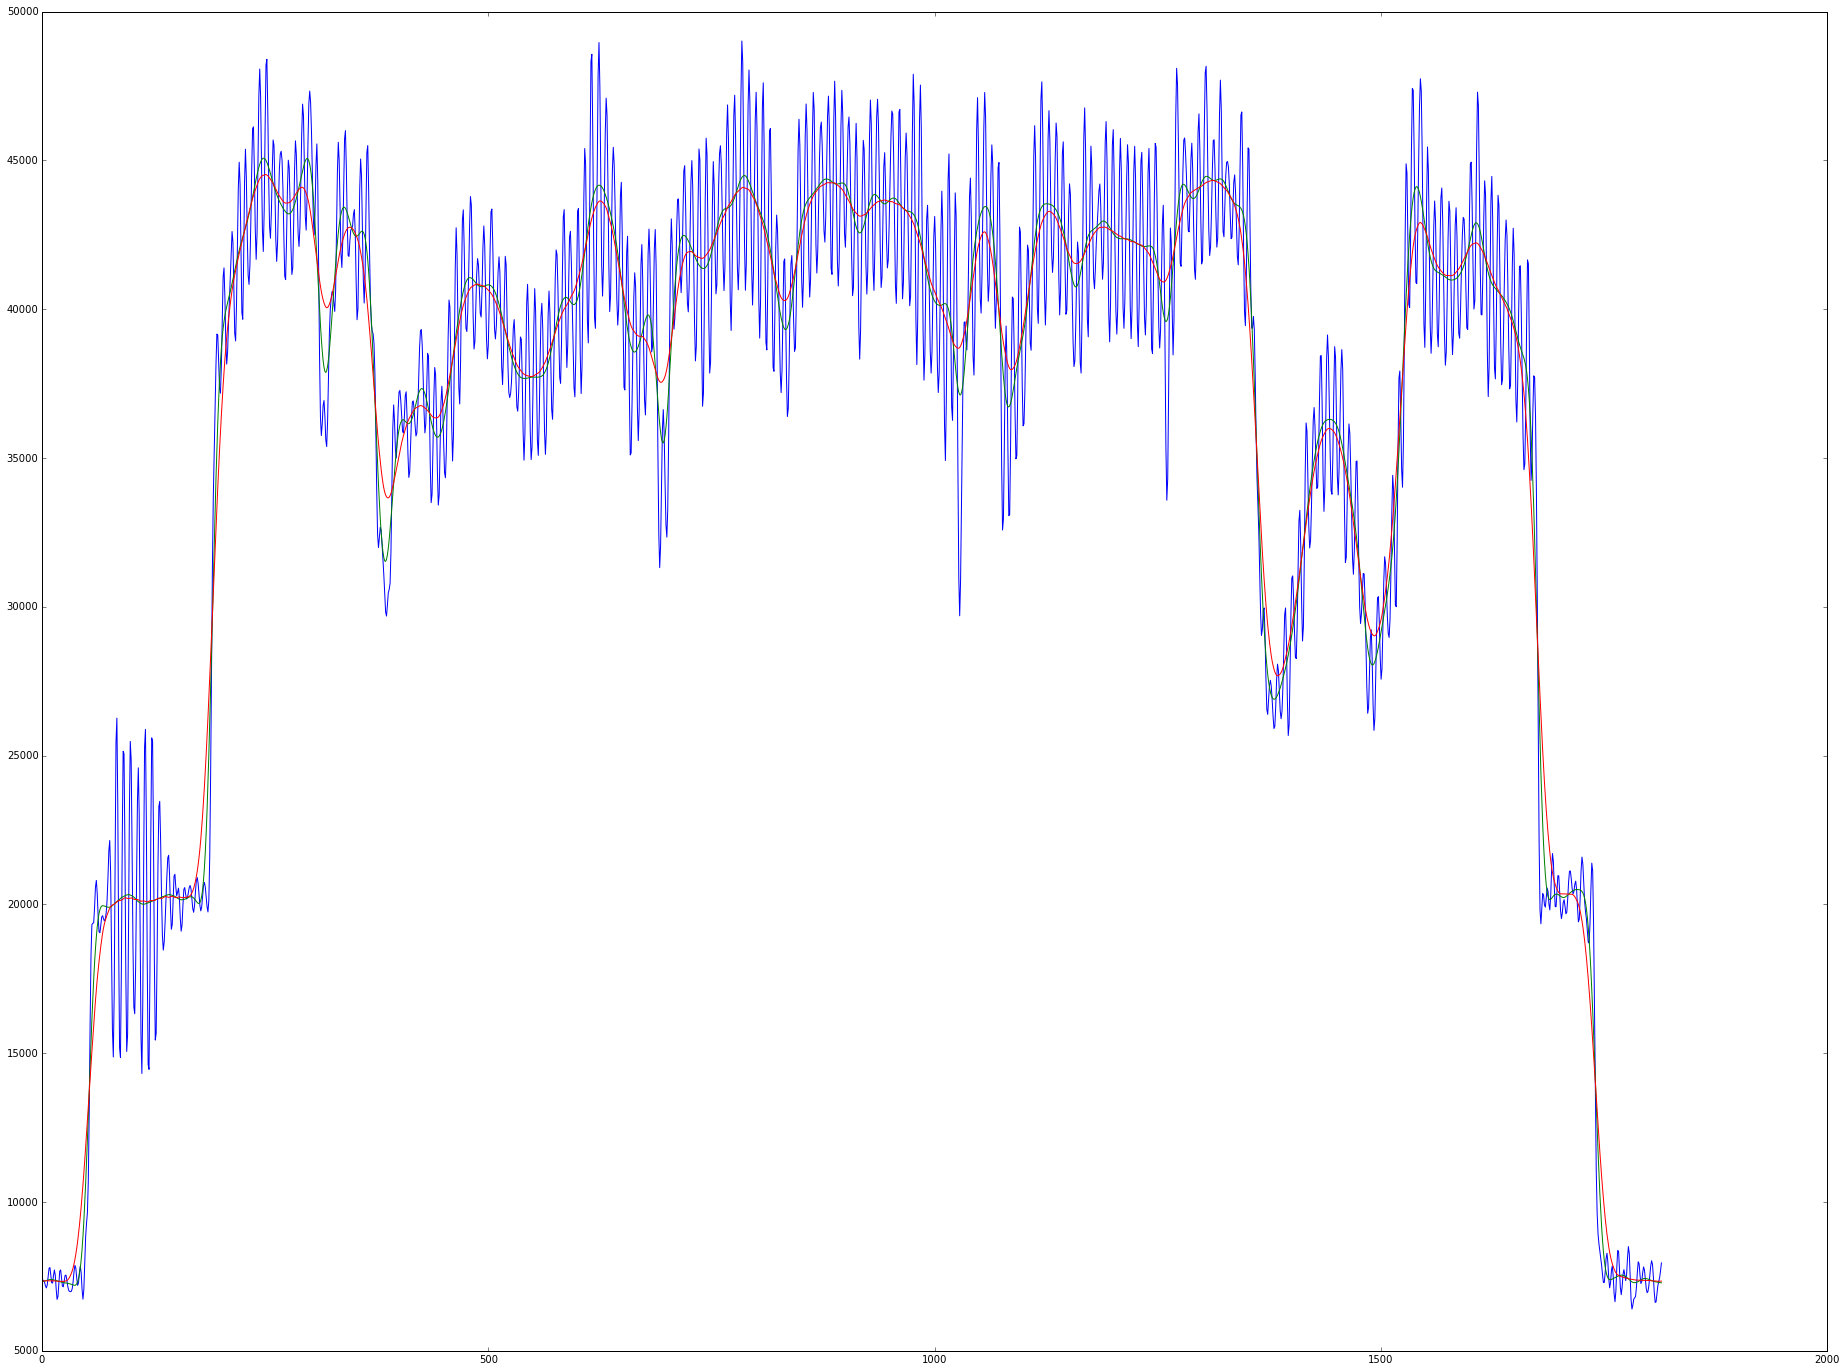

In [607]:
l = 194
plt.plot(data[begin + peaks[l]:begin + peaks[l + 1]])
plt.plot(lpfdata[begin + peaks[l]:begin + peaks[l + 1]])
plt.plot(slpfdata[begin + peaks[l]:begin + peaks[l + 1]])

In [616]:
lbegin_subset[50:60], np.where(lbegin_subset > IREToRaw(-20))[0][0]

(array([ 10414.10435761,  10792.34360403,  11191.98285168,  11608.71844003,
         12038.29851903,  12477.56647442,  12925.32640552,  13382.06699203,
         13848.04667767,  14320.7816233 ]), 57)

In [620]:
offset = (lbegin_subset[57] - IREToRaw(-20)) / (lbegin_subset[57] - lbegin_subset[56])
57 - offset

56.395571577861446

In [621]:
IREToRaw(-20)

13106